# Indirect social influence helps shaping the diffusion of innovations

## Analysis of human decisions

### Libraries import

In [1]:
import numpy as np
import os
import pandas as pd
import os
import pandas as pd
pd.options.mode.chained_assignment = None 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Prediction of human decision using Random Forest clasifier

#### Dependent variable: color chosen (binary). 1: innovation color chosen, 0: no innovation color chosen
#### Independent variables: "Innovation as initial color" (binary), "Innovation as majority color seen" (binary), "Percentage of first neighbors with the innovation color" (float in [0,1]), "Percentage of n-distance neighbors with the innovation color" (float in [0,1])

In [2]:
# random seed
seed=1123

# Load the file as a dataframe
data = pd.read_csv("../Unified_data_edited_innov2.csv")

#Filter the dataset for bot=0 and Setup different than "instructions"
data = data[(data['bot'] == 0) & (data['Setup'] != 'instructions')]

misLabels=["Setting I","Setting II","Setting III","Setting IV"]
misFeatureLabels=["Innovation as initial color", "Innovation as majority color seen", "Percentage of first neighbors with the innovation color", "Percentage of n-distance neighbors with the innovation color"]

# Keep just the columns: innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends, Adopted_color_bin
data = data[['InnovationAsInitialcolor', 'InnovationAsMajorityColorSeen', 'perc_color_neigbors', 'perc_color_friends', 'Adopted_color_bin']]


# Create a Random Forest Classifier to predict the "Adopted_color_bin" column using the other columns as features
# Use two nested cross validation loops, one to tune the hyperparameters and the other to evaluate the model

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest Classifier
rf = RandomForestClassifier()


# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(data.drop('Adopted_color_bin', axis=1), data['Adopted_color_bin'])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to create the final model
final_model = RandomForestClassifier(**best_params)

# Perform nested cross validation to evaluate the model
nested_scores = cross_val_score(final_model, data.drop('Adopted_color_bin', axis=1), data['Adopted_color_bin'], cv=5)

# Print the average accuracy of the nested cross validation
print("Nested Cross Validation Accuracy:", np.mean(nested_scores))


# Fit the model
final_model.fit(data.drop('Adopted_color_bin', axis=1), data['Adopted_color_bin'])

#Save the model
joblib.dump(final_model, "final_model.pkl")


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Nested Cross Validation Accuracy: 0.8421212413435466


['final_model.pkl']

#### Analysis of feature importance. All settings together (a general view)

   importance
2    0.761849
3    0.154449
1    0.063480
0    0.020221


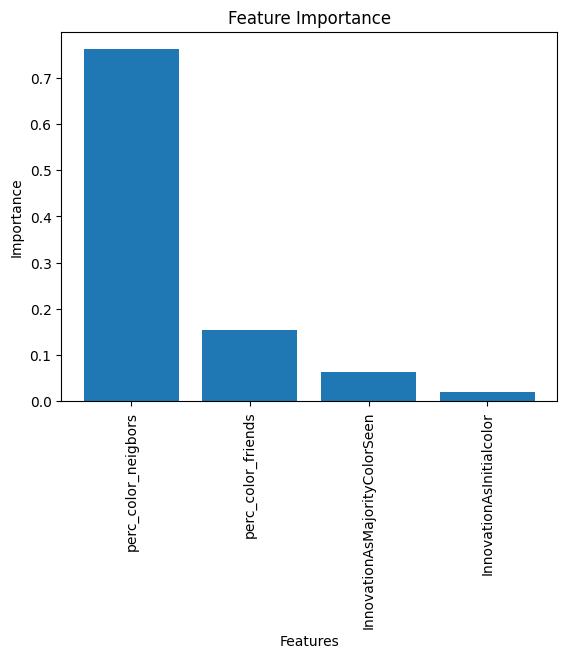

In [3]:
# Load the model
final_model = joblib.load("final_model.pkl")

# Now create a figure of the importance of each feature
# Get feature importances
importances = final_model.feature_importances_
# Get feature names
feature_names = data.drop('Adopted_color_bin', axis=1).columns
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Create plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
#plt.show()

#Save to pdf
plt.savefig("Feature_importance.pdf", format="pdf", bbox_inches="tight")

feature_importances = pd.DataFrame(final_model.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

### Analysis per Experimental setting:
1) Random Forest tunning, using nested cross-validation, tune and compute accuracy and standard deviation for the accuracy
2) Feature importance per setting to establish comparison among settings (experimental treatments)

In [4]:
# Load the file as a dataframe
data = pd.read_csv("../Unified_data_edited_innov2.csv")

#Filter the dataset for bot=0 and Setup different than "instructions"
data = data[(data['bot'] == 0) & (data['Setup'] != 'instructions')]
#Keep just the columns: Setup, innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends, Adopted_color_bin
data = data[['Setup','InnovationAsInitialcolor', 'InnovationAsMajorityColorSeen', 'perc_color_neigbors', 'perc_color_friends', 'Adopted_color_bin']]

# Get feature names
feature_names = data.columns[1:5]

# Create a new dataframe with the columns: Setup, NCV Accuracy, sd
results_df = pd.DataFrame(columns=["Setup", "NCV Accuracy", "sd"])
# add the columns with names in feature_names
results_df = pd.concat([results_df, pd.DataFrame(columns=feature_names)], ignore_index=True)


# Define the hyperparameters to tune for the Random Forest Classifier
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Iterate over the unique values of the "Setup" column
# For each setup, calculate the accuracy of the model using the innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends columns. Store it in the results_df dataframe column "NCV Accuracy
# Compute also the standard deviation of the accuracy using 5-fold cross validation. Store it in the results_df dataframe column sd

# Iterate over the unique values of the "Setup" column
for setup in data['Setup'].unique():

    # Filter the data for the current setup
    setup_data = data[data['Setup'] == setup]
    setup_data.drop('Setup', axis=1, inplace=True) #No hago la predicción con el setup
    
    X = setup_data.drop('Adopted_color_bin', axis=1)
    y = setup_data['Adopted_color_bin']

    rf = RandomForestClassifier()

    # Perform nested cross validation to tune the hyperparameters and evaluate the model
    grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    final_model = RandomForestClassifier(**best_params)

    # Fit the model
    final_model.fit(X, y)
    nested_scores = cross_val_score(final_model, X, y, cv=5)
    
    # Calculate the average accuracy and standard deviation
    avg_accuracy = np.mean(nested_scores)
    std_accuracy = np.std(nested_scores)

    #Compute the importance of each feature
    importances = final_model.feature_importances_
    # importances series to df with column names
    importances_df = pd.DataFrame({'0': importances}, index=feature_names).transpose()
    resultados= pd.DataFrame({'Setup': [setup], 'NCV Accuracy': [avg_accuracy], 'sd': [std_accuracy]})

    # Save the results to the results_df dataframe using pd.concat
    prev_results = pd.concat([resultados, importances_df], ignore_index=False, axis=1, names=["Setup", "NCV Accuracy", "sd"] + feature_names.tolist()) 
    # Desplaza las columnas 3 a la 7 una fila más arriba
    prev_results.iloc[:, 3:7] = prev_results.iloc[:, 3:7].shift(-1)
    #borra la última fila
    prev_results = prev_results[:-1]

    results_df = pd.concat([results_df, prev_results], ignore_index=False, axis=0, names=["Setup", "NCV Accuracy", "sd"] + feature_names.tolist())

    
#Save results_df to a csv file
results_df.to_csv("results_comparison.csv", index=False)

print(results_df)

/var/folders/gm/dmfb8b7n71jgq4nczfq076s40000gn/T/ipykernel_43360/4203978388.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, prev_results], ignore_index=False, axis=0, names=["Setup", "NCV Accuracy", "sd"] + feature_names.tolist())


    Setup  NCV Accuracy        sd  InnovationAsInitialcolor  \
0    AmAz      0.829715  0.000059                  0.031110   
0  LilMor      0.841596  0.006095                  0.016313   
0  RojNar      0.857395  0.004116                  0.053604   
0  VerMag      0.848450  0.005763                  0.053063   

   InnovationAsMajorityColorSeen  perc_color_neigbors  perc_color_friends  
0                       0.394924             0.573967            0.000000  
0                       0.024309             0.843048            0.116330  
0                       0.217052             0.581396            0.147948  
0                       0.215315             0.568970            0.162652  


### Feature importance per experimental setting (pictures)

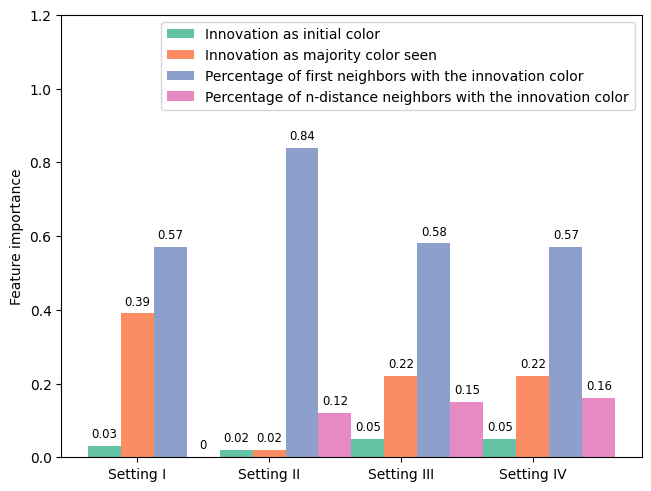

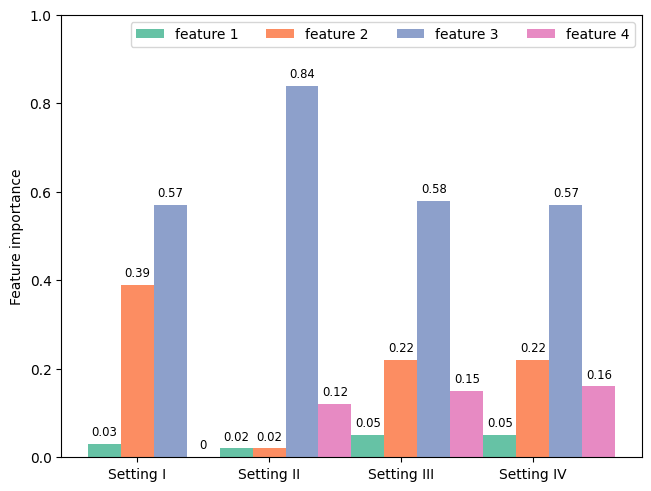

In [5]:
# Load file results_df results_comparison.csv
results_df = pd.read_csv("results_comparison.csv")

# lets try this code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
# Create a dictionary with the data in the results_df dataframe columns 3 to 7. Each key are the column names and the values are the values of the column (4 dimensional vectors)
feature_importances = {}
for feature in results_df.columns[3:]:
    feature_importances[feature] = np.round(results_df[feature].values, 2)
# Rename keys as misFeatureLabels
feature_importances = dict(zip(misFeatureLabels, feature_importances.values()))

x = np.arange(4)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

# select color palette to be sns.color_palette("Set2")
# Create a list of 4 colors from the palette sns.color_palette("Set2")
palette = sns.color_palette("Set2", 4)
#Create a list of 4 colors from the palette
palette = list(palette)  # Convert the color palette iterator to a list

fig, ax = plt.subplots(layout='constrained')

for feature, measurement in feature_importances.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=feature, color=palette[multiplier]) 
    ax.bar_label(rects, padding=4, size='small')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Feature importance')
ax.set_xticks(x + width, misLabels)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 1.2)

#plt.show()
plt.savefig("Feature_importance_all_setups.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)

# Same figure but with smaller legend for the paper
misFeatureLabels2= ["feature 1", "feature 2", "feature 3", "feature 4"]
feature_importances = dict(zip(misFeatureLabels2, feature_importances.values()))


x = np.arange(4)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(layout='constrained')

for feature, measurement in feature_importances.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=feature, color=palette[multiplier]) 
    ax.bar_label(rects, padding=4, size='small')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Feature importance')
ax.set_xticks(x + width, misLabels)
ax.legend(loc='upper right', ncols=4)
ax.set_ylim(0, 1)

#plt.show()
plt.savefig("Feature_importance_all_setups_.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
